In [1]:
import torch 
import torch.nn as nn
import torchvision
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def set_seed(seed):
    """
    Function for setting the seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
DATASET = "IMAGENET1K_V1"
##Dictionnary with all the models
models = {
    "VGG11_no_bn" : torchvision.models.vgg11(weights = DATASET),
    "VGG11_bn" : torchvision.models.vgg11_bn(weights = DATASET),
    "Resnet18" : torchvision.models.resnet18(weights = DATASET),
    "Resnet34" : torchvision.models.resnet34(weights = DATASET),
    "Densenet121" : torchvision.models.densenet121(weights = DATASET),
    "MobileNet-v3-Small" : torchvision.models.mobilenet_v3_small(weights = DATASET)
     }
##Dictionnary with Top 1 accuracy on ImageNet for each model
acc_net = {
    "VGG11_no_bn" : 69.02,
    "VGG11_bn" : 70.37,
    "Resnet18" : 69.758,
    "Resnet34" : 73.314,
    "Densenet121" : 74.434,
    "MobileNet-v3-Small" : 67.668
}
##Dictionnary with nb parameters for each model
param_net = {
    "VGG11_no_bn" : 132863336,
    "VGG11_bn" : 132868840,
    "Resnet18" : 11689512,
    "Resnet34" : 21797672,
    "Densenet121" : 7978856,
    "MobileNet-v3-Small" : 2542856
}

##Dictionnary with nb parameters for each model




Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

In [ ]:
##Computation of inference times
def get_inference_time(model, no_grad = True):
  ''' 
  Get the average inference time of a model averaged over 100 iterations
  Arguments : 
    model 
  Return : 
    np.mean(inferences_time) : mean of the 100 inference times measured for each pass
  '''
  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)
  model.eval()
  model = model.to(device)

  inference_times = []
  fake_image = torch.rand((64, 3, 256, 256)).to(device)
  if no_grad == True:
    with torch.no_grad():
      #gpu warmup
      for j in range(0,10):
        model(fake_image)

      for i in range(1,100):
        torch.cuda
        start.record()
        model(fake_image)
        end.record()
        torch.cuda.synchronize()
        inference_times.append(start.elapsed_time(end))
  else:
    for i in range(1,100):
        start.record()
        model(fake_image)
        end.record()
        torch.cuda.synchronize()
        inference_times.append(start.elapsed_time(end))

  return np.mean(inference_times)

inf_net = {}
for key, item in models.items():
    inf_net[key] = get_inference_time(item, True)

inf_net_grad = {}
for key, item in models.items():
    inf_net_grad[key] = get_inference_time(item, False)






# QUESTION 1.1.A

First trend : the longer the inference time, the higher the accuracy on Image Net. It would make sens because more inference time means more computations so deeper models with more parameters that are supposedly more efficient.

The second trend is the higher the number of parameters, the higher the inference time. It would make sense as more parameters needs more computations, which take indeed more time. One good example is VGG11 that has a lower inference time without batch normalization, as it does less computation than with batch normalization.

Text(0.5, 1.0, 'Inference time vs number of parameters for several models')

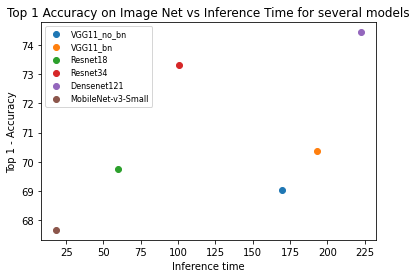

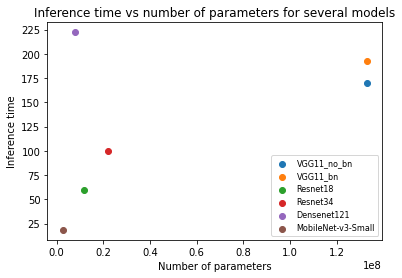

In [ ]:
plt.figure()
for key, _ in models.items():
  plt.scatter(inf_net[key], acc_net[key], label = key)
plt.xlabel("Inference time")
plt.ylabel("Top 1 - Accuracy")
plt.legend(prop={'size': 8})
plt.title("Top 1 Accuracy on Image Net vs Inference Time for several models")

plt.figure()
for key, _ in models.items():
  plt.scatter(param_net[key], inf_net[key], label = key)
plt.xlabel("Number of parameters")
plt.ylabel("Inference time")
plt.legend(prop={'size': 8})
plt.title("Inference time vs number of parameters for several models")

# Question 1.1.B

When the gradients are not disabled, the model has to save the values of the gradients in the memory, even if they are not used. So it adds a step to the forward pass, hence it should take more time.

torch.no_grad() disables the gradient computation that are not useful for inference.

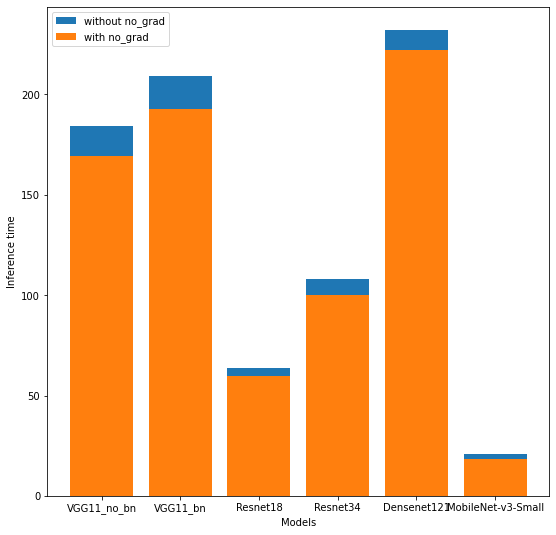

In [ ]:
plt.figure(figsize = (9,9))
plt.bar(list(models.keys()), inf_net_grad.values(), label = "without no_grad")
plt.xlabel("Models")
plt.ylabel("Inference time")
plt.bar(list(models.keys()), inf_net.values(), label = "with no_grad")
plt.title("")
plt.legend()



# Question 1.1.C

In [ ]:
def get_memory_allocated(model, no_grad = True):
  ''' 
  Get the allocated memory after a forward pass of a model
  Arguments : 
    model
    no_grad : True if no gradients and False if with gradients
  Returns : 
    memory_2 - memory_2 : memory allocated after a forward pass
  '''
  torch.cuda.empty_cache()
  fake_image = torch.rand((64, 3, 256, 256)).to(device)
  model = model.to(device)
  model.eval()

  if no_grad == True:
    with torch.no_grad():
      memory_1 = torch.cuda.memory_allocated()
      y = model(fake_image)
      memory_2 = torch.cuda.memory_allocated()
      return memory_2 - memory_1
  else:
    memory_1 = torch.cuda.memory_allocated()
    y = model(fake_image)
    memory_2 = torch.cuda.memory_allocated()
    return memory_2 - memory_1

memory_net = {}
for key, item in models.items():
    memory_net[key] = get_memory_allocated(item, True)

memory_net_grad = {}
for key, item in models.items():
    memory_net_grad[key] = get_memory_allocated(item, False)





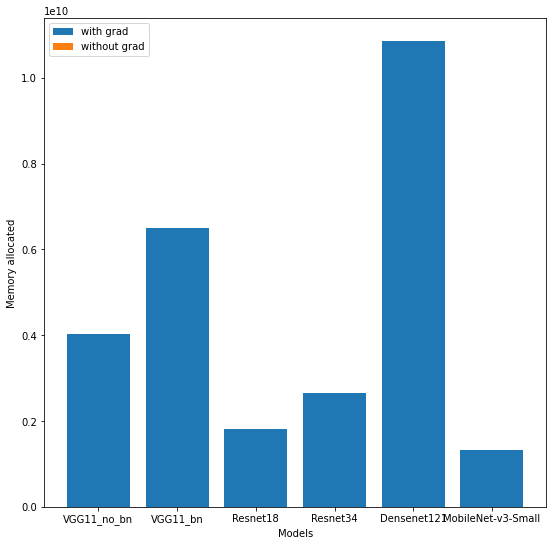

In [ ]:
plt.figure(figsize = (9,9))
plt.bar(list(models.keys()), memory_net_grad.values(), label = "with grad")
plt.xlabel("Models")
plt.ylabel("Memory allocated")
plt.bar(list(models.keys()), memory_net.values(), label = "without grad")
plt.title("")
plt.legend()

# QUESTION 1.2.A



In [4]:
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms

    
import torch

from torchvision.datasets import CIFAR100
from torch.utils.data import random_split
from torchvision import transforms

class AddGaussianNoise(torch.nn.Module):
  def __init__(self, mean=0., std=0.1):
          self.mean = mean
          self.std = std

  def __call__(self, img):
      #######################
          return img + torch.normal(self.mean, self.std, size = img.size())
  def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

def add_augmentation(augmentation_name, transform_list):
    """
    Adds an augmentation transform to the list.
    Args:
        augmentation_name: Name of the augmentation to use.
        transform_list: List of transforms to add the augmentation to.
    """
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    # Create a new transformation based on the augmentation_name.

    liste_aug =[]
    for name in augmentation_name:
      if name == "color":
        transform_list.append(transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1))
      if name == "rotation":
        transform_list.append(transforms.RandomRotation(0.25))
      if name == "noise":
        transform_list.append(AddGaussianNoise())
    
    # Add the new transformation to the list.
    

    #######################
    # END OF YOUR CODE    #
    #######################


def get_train_validation_set(data_dir, validation_size=5000, augmentation_name=None):
    """
    Returns the training and validation set of CIFAR100.
    Args:
        data_dir: Directory where the data should be stored.
        validation_size: Size of the validation size
        augmentation_name: The name of the augmentation to use.
    Returns:
        train_dataset: Training dataset of CIFAR100
        val_dataset: Validation dataset of CIFAR100
    """

    mean = (0.5071, 0.4867, 0.4408)
    std = (0.2675, 0.2565, 0.2761)

    train_transform = [transforms.Resize((224, 224)),
                       transforms.ToTensor(),
                       transforms.Normalize(mean, std)]
    if augmentation_name is not None:
        add_augmentation(augmentation_name, train_transform)
    train_transform = transforms.Compose(train_transform)

    val_transform = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)])

    # We need to load the dataset twice because we want to use them with different transformations
    train_dataset = CIFAR100(root=data_dir, train=True, download=True, transform=train_transform)
    val_dataset = CIFAR100(root=data_dir, train=True, download=True, transform=val_transform)

    # Subsample the validation set from the train set
    if not 0 <= validation_size <= len(train_dataset):
        raise ValueError("Validation size should be between 0 and {0}. Received: {1}.".format(
            len(train_dataset), validation_size))

    train_dataset, _ = random_split(train_dataset,
                                    lengths=[len(train_dataset) - validation_size, validation_size],
                                    generator=torch.Generator().manual_seed(42))
    _, val_dataset = random_split(val_dataset,
                                  lengths=[len(val_dataset) - validation_size, validation_size],
                                  generator=torch.Generator().manual_seed(42))

    return train_dataset, val_dataset


def get_test_set(data_dir, noise = "False"):
    """
    Returns the test dataset of CIFAR100.
    Args:
        data_dir: Directory where the data should be stored
    Returns:
        test_dataset: The test dataset of CIFAR100.
    """

    mean = (0.5071, 0.4867, 0.4408)
    std = (0.2675, 0.2565, 0.2761)

    if noise == True:
        test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std),
                                        AddGaussianNoise(0, 0.1)])
    else:
        test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)])
    
    test_dataset = CIFAR100(root=data_dir, train=False, download=True, transform=test_transform)
    return test_dataset

data_dir = "data"

train_set, val_set = get_train_validation_set(data_dir)
test_set = get_test_set(data_dir)

batch_size = 32

train_loader = DataLoader(
    train_set, batch_size, shuffle = True, drop_last = True)


val_loader = DataLoader(
    val_set, batch_size, shuffle = True, drop_last = False)


test_loader = DataLoader(
    test_set, batch_size, shuffle = True, drop_last = False)




  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


In [5]:
class EarlyStopper:
  def __init__(self, patience = 3):
    self.patience = patience
    self.counter = 0
    self.max = 0
  def early_stop(self, validation_accuracy):
    if validation_accuracy > self.max:
      self.max = validation_accuracy
      self.counter = 0
    elif validation_accuracy < self.max:
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False
  


def train_batch(model, dataloader, optimizer, criterion):
    model.train()
    loss_per_batch = []
    for batch_num, data in enumerate(train_loader):

      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      #Gradients to zero
      optimizer.zero_grad()

      outputs = model(images)

      #Loss calculated then backprop and weight update
      loss = criterion(outputs, labels)
      loss.backward()
      loss_per_batch.append(loss.item())

      optimizer.step()

    return loss_per_batch

def eval_batch(model, dataloader):
    running_correct = 0
    for batch_num, data in enumerate(dataloader):
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        pred = np.argmax(outputs.cpu().detach().numpy(), axis = 1)
        #Count and accuracy computation
        running_correct += np.sum(labels.cpu().numpy() == pred)

    return (running_correct/ len(dataloader.dataset)) * 100

def plot_functions(training_loss, accuracy_loss, epochs):
    '''
    Plot accuracy curbs and loss curbs
    '''
    plt.figure()

    plt.subplot(1,2,1)
    plt.plot(np.arange(1,epochs + 1), training_loss)
    plt.title("Loss function")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.plot(np.arange(1,epochs + 1), accuracy_loss)
    plt.title("Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

def train_model(model, train_loader, val_loader, epochs):

  optimizer = torch.optim.Adam(model.parameters())
  criterion = torch.nn.CrossEntropyLoss()
  model = model.to(device)
  loss_per_epoch = []
  accuracy_per_epoch = []
  early_stopper = EarlyStopper(patience = 3)
  count_epoch = 0
  for epoch in tqdm(range(epochs)):
    
    #Training for each epoch
    loss_per_batch = train_batch(model, train_loader, optimizer, criterion)
    print("Epoch {} ==> Loss : {}".format(epoch+1, np.mean(loss_per_batch)))

    #Now Validation for each epoch
    accuracy_per_batch = eval_batch(model, val_loader)
    #Early_stopping on validation accuracy
    if early_stopper.early_stop(accuracy_per_batch):
      break
    count_epoch +=1
    print("Epoch {} ==> Accuracy : {}".format(epoch+1, accuracy_per_batch))

    #We store the values of the loss and accuracies to plot
    loss_per_epoch.append(np.mean(loss_per_batch))
    accuracy_per_epoch.append(accuracy_per_batch)

    print("Epoch {} ==> Accuracy : {}".format(epoch+1, accuracy_per_batch))

  #Plot of the functions
  plot_functions(loss_per_epoch, accuracy_per_epoch, count_epoch)

  return model

In [6]:
# Set gradient to zero for all layers of a model
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

#10 classes in CIFAR-10
num_classes = 100

#Finetuning the last layer and initialization with uniform
model_transfer = torchvision.models.resnet18(weights = DATASET)

#Deactivate gradients for all layers
set_parameter_requires_grad(model_transfer, True)
#Finetuning of the last linear layer
num_ftrs = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_ftrs, num_classes)
model_transfer.fc.weight = nn.init.normal_(model_transfer.fc.weight, 0, 0.01)
model_transfer.fc.bias = nn.init.zeros_(model_transfer.fc.bias)

#Print parameters used during training
params_to_update = []
print("Params to learn :")
for name, param in model_transfer.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("\t", name)


Params to learn :
	 fc.weight
	 fc.bias


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 ==> Loss : 2.309209620799991


  5%|▌         | 1/20 [02:18<43:52, 138.54s/it]

Epoch 1 ==> Accuracy : 52.86
Epoch 1 ==> Accuracy : 52.86
Epoch 2 ==> Loss : 1.6432613772823665


 10%|█         | 2/20 [04:26<39:44, 132.50s/it]

Epoch 2 ==> Accuracy : 53.68000000000001
Epoch 2 ==> Accuracy : 53.68000000000001
Epoch 3 ==> Loss : 1.527226803143367


 15%|█▌        | 3/20 [06:35<36:59, 130.57s/it]

Epoch 3 ==> Accuracy : 55.44
Epoch 3 ==> Accuracy : 55.44
Epoch 4 ==> Loss : 1.4601743298438332


 20%|██        | 4/20 [08:42<34:30, 129.42s/it]

Epoch 4 ==> Accuracy : 54.82
Epoch 4 ==> Accuracy : 54.82
Epoch 5 ==> Loss : 1.4187999550004093


 25%|██▌       | 5/20 [10:51<32:16, 129.08s/it]

Epoch 5 ==> Accuracy : 55.300000000000004
Epoch 5 ==> Accuracy : 55.300000000000004
Epoch 6 ==> Loss : 1.3853502957359656


 30%|███       | 6/20 [12:59<30:01, 128.68s/it]

Epoch 6 ==> Accuracy : 56.46
Epoch 6 ==> Accuracy : 56.46
Epoch 7 ==> Loss : 1.3631506610137132


 35%|███▌      | 7/20 [15:07<27:51, 128.59s/it]

Epoch 7 ==> Accuracy : 55.7
Epoch 7 ==> Accuracy : 55.7
Epoch 8 ==> Loss : 1.3430725676915045


 40%|████      | 8/20 [17:15<25:41, 128.50s/it]

Epoch 8 ==> Accuracy : 55.620000000000005
Epoch 8 ==> Accuracy : 55.620000000000005
Epoch 9 ==> Loss : 1.3229374298839107


 45%|████▌     | 9/20 [19:23<23:32, 128.39s/it]

Epoch 9 ==> Accuracy : 56.64
Epoch 9 ==> Accuracy : 56.64
Epoch 10 ==> Loss : 1.3106673553183272


 50%|█████     | 10/20 [21:31<21:22, 128.26s/it]

Epoch 10 ==> Accuracy : 55.279999999999994
Epoch 10 ==> Accuracy : 55.279999999999994
Epoch 11 ==> Loss : 1.2997952691182642


 55%|█████▌    | 11/20 [23:39<19:13, 128.16s/it]

Epoch 11 ==> Accuracy : 56.06
Epoch 11 ==> Accuracy : 56.06
Epoch 12 ==> Loss : 1.286602782427332


 55%|█████▌    | 11/20 [25:48<21:06, 140.73s/it]


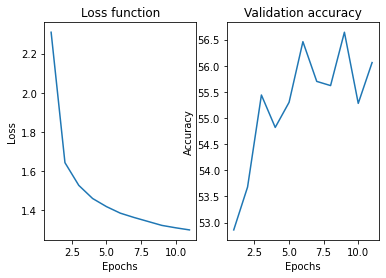

In [7]:
y = train_model(model_transfer, train_loader, val_loader, 20)

In [8]:
accuracy_test = np.round(eval_batch(model_transfer, test_loader), 4)
print(f"The accuracy on test set is {accuracy_test}%.")

The accuracy on test set is 55.78%.


In [9]:
data_dir = "data"

test_set_noise = get_test_set(data_dir, noise = True)

batch_size = 32



test_loader_noise = DataLoader(
    test_set_noise, batch_size, shuffle = True, drop_last = False)

accuracy_test_noise = np.round(eval_batch(model_transfer, test_loader_noise), 4)
print(f"The accuracy on test set with noise is {accuracy_test_noise}%.")

Files already downloaded and verified
The accuracy on test set with noise is 47.8%.


It is important to notice that I am using a batch size of 32, as higher would not run in google colab. The model would not be as robust to noise if my batch size was higher, like 128. 

# Question 1.2.B

In [10]:
data_dir = "data"

train_set, val_set = get_train_validation_set(data_dir, augmentation_name= ["horizontal_flip", "color"])
test_set = get_test_set(data_dir)

batch_size = 32

train_loader_aug = DataLoader(
    train_set, batch_size, shuffle = True, drop_last = True)


val_loader_aug = DataLoader(
    val_set, batch_size, shuffle = True, drop_last = False)


test_loader_aug = DataLoader(
    test_set, batch_size, shuffle = True, drop_last = False)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Set gradient to zero for all layers of a model
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

#10 classes in CIFAR-10
num_classes = 100

#Finetuning the last layer and initialization with uniform
model_transfer_aug = torchvision.models.resnet18(weights = DATASET)

#Deactivate gradients for all layers
set_parameter_requires_grad(model_transfer_aug, True)
#Finetuning of the last linear layer
num_ftrs = model_transfer_aug.fc.in_features
model_transfer_aug.fc = nn.Linear(num_ftrs, num_classes)
model_transfer_aug.fc.weight = nn.init.normal_(model_transfer_aug.fc.weight, 0, 0.01)
model_transfer_aug.fc.bias = nn.init.zeros_(model_transfer_aug.fc.bias)

#Print parameters used during training
params_to_update = []
print("Params to learn :")
for name, param in model_transfer_aug.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("\t", name)

Params to learn :
	 fc.weight
	 fc.bias


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 ==> Loss : 2.3071647434790816


  5%|▌         | 1/20 [02:07<40:17, 127.22s/it]

Epoch 1 ==> Accuracy : 52.64
Epoch 1 ==> Accuracy : 52.64
Epoch 2 ==> Loss : 1.6493574106167594


 10%|█         | 2/20 [04:14<38:07, 127.10s/it]

Epoch 2 ==> Accuracy : 53.76
Epoch 2 ==> Accuracy : 53.76
Epoch 3 ==> Loss : 1.5295733433444674


 15%|█▌        | 3/20 [06:21<36:02, 127.18s/it]

Epoch 3 ==> Accuracy : 55.74
Epoch 3 ==> Accuracy : 55.74
Epoch 4 ==> Loss : 1.462280471921815


 20%|██        | 4/20 [08:28<33:54, 127.17s/it]

Epoch 4 ==> Accuracy : 56.10000000000001
Epoch 4 ==> Accuracy : 56.10000000000001
Epoch 5 ==> Loss : 1.4152640512115078


 25%|██▌       | 5/20 [10:35<31:46, 127.10s/it]

Epoch 5 ==> Accuracy : 55.76
Epoch 5 ==> Accuracy : 55.76
Epoch 6 ==> Loss : 1.387522716398429


 30%|███       | 6/20 [12:43<29:43, 127.41s/it]

Epoch 6 ==> Accuracy : 55.86
Epoch 6 ==> Accuracy : 55.86
Epoch 7 ==> Loss : 1.3660112814408107


 35%|███▌      | 7/20 [14:50<27:34, 127.26s/it]

Epoch 7 ==> Accuracy : 56.8
Epoch 7 ==> Accuracy : 56.8
Epoch 8 ==> Loss : 1.3499990881845927


 40%|████      | 8/20 [16:57<25:25, 127.17s/it]

Epoch 8 ==> Accuracy : 56.620000000000005
Epoch 8 ==> Accuracy : 56.620000000000005
Epoch 9 ==> Loss : 1.321118808657482


 45%|████▌     | 9/20 [19:04<23:18, 127.14s/it]

Epoch 9 ==> Accuracy : 56.2
Epoch 9 ==> Accuracy : 56.2
Epoch 10 ==> Loss : 1.3120117909453841


 45%|████▌     | 9/20 [21:11<25:54, 141.31s/it]


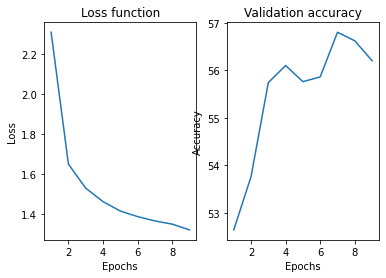

In [12]:
y_aug = train_model(model_transfer_aug, train_loader_aug, val_loader_aug, 20)

In [13]:
accuracy_test = np.round(eval_batch(model_transfer_aug, test_loader_aug), 4)
print(f"The accuracy on test set is {accuracy_test}%.")

The accuracy on test set is 56.59%.
